### Protein Composition Statistics

The analysis functions are located in `./indels/proteins.py`, which draws general functions from `./indels/ind.py`

In [1]:
# Perform the initialization and imports
import sys
import pickle
import re
import os
import csv
import argparse
import math
import pprint

from string import ascii_lowercase
from collections import Counter, defaultdict, OrderedDict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from Bio import SeqIO, AlignIO
from Bio.SeqRecord import SeqRecord
from Bio.Alphabet import IUPAC
from Bio.Seq import Seq
from Bio.Emboss.Applications import NeedleallCommandline

# Demand Python 3.
if sys.version_info[0] < 3:
    print("Python 3 is required, but you are using Python %i.%i.%i") % (
        sys.version_info[0], sys.version_info[1], sys.version_info[2])
    sys.exit(1)

In [2]:
# Retrieve the specific functions from ind and proteins.py
indels_path="/home/mp/InDelScanner"  # /PATH/TO/InDelScanner
if indels_path not in sys.path:
    sys.path.append(indels_path)

In [3]:
from ipynb.fs.defs.Library_diversity import convert_variant_to_dict

In [4]:
os.chdir("/mnt/c/Users/Maya/Documents/03_Kinases/")

with open('mek.pickle', 'rb') as f:
    mek = pickle.load(f)

df_all = pd.DataFrame.from_dict(mek).fillna(0).sort_values(by=['high', 'med', 'low-t'], ascending=False)

### How many variants are there?

In [5]:
aa_2 = ['A', 'Δ']
aa_12 = ['A','G','P','Y','D','K','M','V','I','L','F','W']
aa_13 = aa_12 +  ['Δ']
splimlib = {'6': aa_12, '9': aa_12, '11': aa_12, '13': aa_12, '7a': aa_13, '8a': aa_2}

def is_variant_in_expected_set(m_by_pos, splimlib):
    for k, a in m_by_pos.items():
        if k not in splimlib.keys():
            return False
        elif a not in splimlib[k]:
            return False
        
    return True

In [6]:
def get_vars_by_count(gate, cutoff, correct_only):
    vars_by_count = OrderedDict((i, 0) for i in range(1, cutoff +1))

    for mutation_string, c in mek[gate].items():
        if correct_only:
            # m_by_pos[position] = AA
            m_by_pos = convert_variant_to_dict(mutation_string)
            if not is_variant_in_expected_set(m_by_pos, splimlib):
                continue
        if c >= cutoff:
            vars_by_count[cutoff] +=1
        else:
            vars_by_count[c] +=1
    
    return vars_by_count

def poisson_plot_for_choosing_cutoff(gate, cutoff, plot_title, colours = ['b', 'c'], filename=""):
    
    everything = get_vars_by_count(gate, cutoff, correct_only=False)
    expected = get_vars_by_count(gate, cutoff, correct_only=True)
    
    ind = np.arange(len(everything))  # the x locations for the groups
    width = 0.35       # the width of the bars
        
    fig, ax = plt.subplots()
    
    rects1 = ax.bar(ind, everything.values(), width, color=colours[0])
    rects2 = ax.bar(ind + width, expected.values(), width, color=colours[1])

    # add some text for labels, title and axes ticks
    ax.set_title(plot_title, x=0.5, y=0.9)
    ax.set_ylabel('# of variants')
    ax.set_xlabel('Sequencing observation count')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(everything.keys())

    ax.legend((rects1[0], rects2[0]), ('All', 'Expected'))

    plt.tight_layout()
    if filename:
        plt.savefig(filename)
    plt.show()
    
    
def poisson_plot_for_choosing_cutoff_zoomed(gate, cutoff, plot_title, sel_start = 0, colours = ['b', 'c'], filename=""):
    
    everything = get_vars_by_count(gate, cutoff, correct_only=False)
    expected = get_vars_by_count(gate, cutoff, correct_only=True)
    
    ind = np.arange(len(everything))  # the x locations for the groups
    width = 0.35       # the width of the bars
        
    fig, ax = plt.subplots()
    
    rects1 = ax.bar(ind[sel_start:-1], list(everything.values())[sel_start:-1], width, color=colours[0])
    rects2 = ax.bar(ind[sel_start:-1] + width, list(expected.values())[sel_start:-1], width, color=colours[1])

    # add some text for labels, title and axes ticks
    ax.set_title(plot_title, x=0.5, y=0.9)
    ax.set_ylabel('# of variants')
    ax.set_xlabel('Sequencing observation count')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(everything.keys())

    ax.legend((rects1[0], rects2[0]), ('All', 'Expected'))

    plt.tight_layout()
    if filename:
        plt.savefig(filename)
    plt.show()

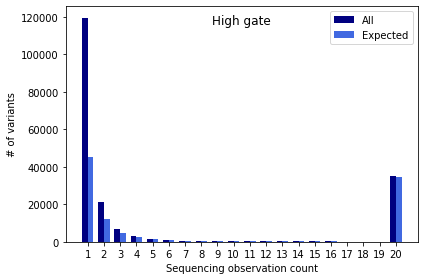

In [7]:
poisson_plot_for_choosing_cutoff('high', 20, 'High gate', colours=['navy', 'royalblue'], filename='Seq_cutoffs_high.png')

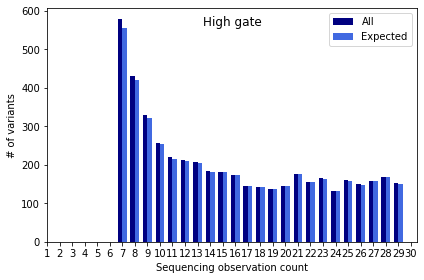

In [8]:
poisson_plot_for_choosing_cutoff_zoomed('high', 30, 'High gate', sel_start = 6, colours=['navy', 'royalblue'], filename='Seq_cutoffs_high_zoom.png')

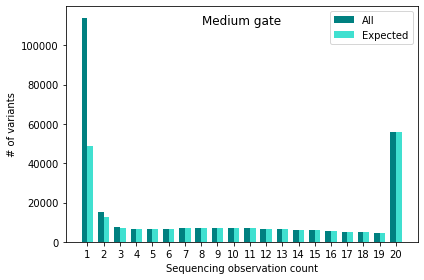

In [9]:
poisson_plot_for_choosing_cutoff('med', 20, 'Medium gate', colours=['teal', 'turquoise'], filename= 'Seq_cutoffs_medium.png')

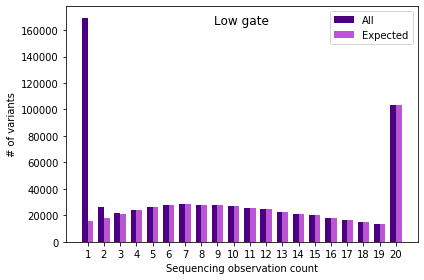

In [10]:
poisson_plot_for_choosing_cutoff('low-t', 20, 'Low gate', colours=['indigo', 'mediumorchid'], filename='Seq_cutoffs_low.png')

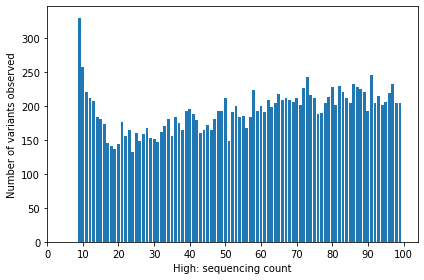

In [11]:
cutoff = 100
vars_by_count = OrderedDict((i, 0) for i in range(1, cutoff +1))
for c in mek['high'].values():
    if c >= cutoff:
        vars_by_count[cutoff] +=1
    else:
        vars_by_count[c] +=1

plt.bar(list(vars_by_count.keys())[8:-1], list(vars_by_count.values())[8:-1])
plt.xticks(np.arange(0, cutoff+1, 10))
plt.xlabel('High: sequencing count')
plt.ylabel('Number of variants observed')
plt.tight_layout()
plt.savefig('Seq_cutoffs_high_2.png')
plt.show()

### How many times does the WT appear in each bin?

In [12]:
df_all.loc['6P/9I/11L/13P']

high     51.0
med      36.0
low-t    34.0
Name: 6P/9I/11L/13P, dtype: float64

In [13]:
df_all.loc['6P/9A/11A/13P']

high      0.0
med       6.0
low-t    20.0
Name: 6P/9A/11A/13P, dtype: float64

In [14]:
df_all.loc['6P/9I/11L/13P']/df_all.loc['6P/9I/11L/13P'].sum()

high     0.421488
med      0.297521
low-t    0.280992
Name: 6P/9I/11L/13P, dtype: float64

Cutoff criteria for variants to be considered acrive are built based on WT:
- 51 or more reads in high bin
- more reads in high than in low bin
- more reads in high than in medium bin
- 42% or more reads total in high bin

In [15]:
df_51 = df_all.loc[(df_all['high'] >= 51)]

In [16]:
df_51.describe()

,high,med,low-t
count,29603.000000,29603.000000,29603.000000
mean,146.213931,11.612810,11.432895
std,87.679320,15.697705,10.396649
min,51.000000,0.000000,0.000000
25%,87.000000,0.000000,5.000000
50%,123.000000,3.000000,10.000000
75%,177.000000,19.000000,16.000000
max,1185.000000,232.000000,453.000000


In [17]:
df_pos = df_all.loc[(df_all['high'] >= 51) & (df_all['high'] > df_all['low-t']) & (df_all['high'] > df_all['med']) &
                   (df_all['high'] > 0.42*(df_all['high'] + df_all['med'] + df_all['low-t']))]
# this filtering removed 35 variants based on H>L, H>M condition and 4 based on %H. Leaves one variants with a stop codon.

In [18]:
df_pos[df_pos.index.str.contains('*', regex=False)]

,high,med,low-t
6L/7aI/9A/9a*,53.0,24.0,23.0


In [19]:
df_pos = df_pos.drop(['6L/7aI/9A/9a*'])

In [20]:
df_pos.describe()

,high,med,low-t
count,29563.000000,29563.000000,29563.000000
mean,146.294524,11.512363,11.300274
std,87.695445,15.393163,8.303405
min,51.000000,0.000000,0.000000
25%,87.000000,0.000000,5.000000
50%,123.000000,3.000000,10.000000
75%,177.000000,19.000000,16.000000
max,1185.000000,136.000000,80.000000


We now have a total of 29,563 variants in the active dataset.

In [21]:
df_all.loc['6P/9I/11W/13P']

high     32.0
med       0.0
low-t    19.0
Name: 6P/9I/11W/13P, dtype: float64